Data_loader return dimensions:  torch.Size([3, 1, 28, 28])
0 :
tensor([9, 5, 5])
1 :
tensor([9, 5, 5])
2 :
tensor([9, 5, 5])


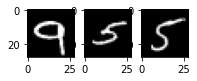

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

''' Parameters (CHange Anything Here!) '''
transform = transforms.ToTensor()
batch_size = 3


''' Code Starts Here '''
#Data MNIST
mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset= mnist_data, batch_size = batch_size, shuffle = True)

dataiter = iter(data_loader)
images, labels = dataiter.next()
print("Data_loader return dimensions: ", images.shape)
input_size = images.shape[2]

# plotting out the images
plt.figure(figsize = (9,2)) # figsize(side spacing, height spacing (likely))
plt.gray()
for i, item in enumerate(images):
    if i >= 9:
        break
    plt.subplot(2, 9, i + 1)
    plt.imshow(item[0])

for j, label in enumerate(labels):
    print(j, ":")
    print(labels)

In [4]:
# testing model
''' Conv 2d Layer 
#         Accessible Variables: .weights(Tensor), .bias(Tensor)
#         parameters :
#         torch.nn.Conv2d(in_channels, out_channels, 
#                         kernel_size, stride=1, padding=0, 
#                         dilation=1, groups=1, bias=True, 
#                         padding_mode='zeros')
'''
class Autoencoder_Test(nn.Module):
    def __init__(self):
        super().__init__()

        #Image size:N, 28, 28
        self.conv1 = nn.Conv2d(1, 2, 3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(1, 2, 3, stride=2, padding=1)
        
    def forward(self, x):
        encoded = self.conv1(x)
        #encoded is the output of the layer
        return encoded
    
model = Autoencoder_Test()

generator = model.parameters() #(returns a generator)

# for param in conv1.parameters():
#     param.requires_grad = False

# generator from model.params()
# generator returns : filter weights in the first iteration, then the weights, then filter weights again
# if there are 2 - (3x3) feature filters in the layer, the dimension of tensor returned will be: (2, 1, 3, 3)
count = 0
for params in generator:
    count += 1
    print(count, ":")
#     print(params)
    npweight = params.detach().numpy()
    print(npweight.shape)
    print(npweight)


1 :
(2, 1, 3, 3)
[[[[-0.30069196  0.11788306 -0.08021498]
   [ 0.1447672  -0.21761513  0.2695081 ]
   [-0.27041215  0.05243075 -0.00734672]]]


 [[[-0.25542682 -0.208678    0.08023819]
   [-0.26417443 -0.05881071 -0.10150516]
   [ 0.17048189  0.15289119  0.22528318]]]]
2 :
(2,)
[-0.26474327 -0.04443625]


In [5]:
# Batch Training loop
# Hidden Units here is to be defined as feature maps
# Spatial Sparsity: For every feature Filter, after batch prediction, pick the highest output activity and set the rest to 0
# Lifetime Sparsity: For every feature Filter, after batch prediction, pick the hightst k% of all the filters picked in Spatial Sparsity
from sortedcontainers import SortedList, SortedDict

num_epochs = 1
sorted_list = SortedList()
winnersMap = {}

for epoch in range(num_epochs):
#     for (img, labels) in data_loader:
    img, labels = dataiter.next()
    feature_map = model(img) # returns the feature maps of all batch examples in order
    
#     for feature in range(feature_map.shape[1]): # pick the feature element to iterate through
#         for curr_batch in range(feature_map.shape[0]): # pick batch to iterate through
# #     print (img.shape)
# #     print("\n Before reshaping dataLoader imgs :\n", img)
# #     print("\n After reshaping dataLoader imgs :\n", img.view(img.shape[1], batch_size, input_size, input_size))

#     featur_map_mod = feature_map.view(feature)
#     print("\n Before reshaping prediction :\n", feature_map(feature_map.shape[1], batch_size, input_size, input_size)
#     print("\n Shape of the Prediction tensor after .view : \n", feature_map.view(feature_map.shape[1], batch_size, input_size, input_size).shape)
#     print("\n After reshaping prediction imgs :\n", feature_map.view(feature_map.shape[1], batch_size, input_size, input_size))

#     # Checking if the feature maps are the same before and after modifying the rows
#     for j, label in enumerate(labels):
#     print(j, ":")
#     print(labels)
    
    # Summing up the activation maps to find the maximum activation hidden map from the the batch
    summation = torch.sum(img, (2, 3)) # reduce the 3rd and 4th dimension of the tensor. Summation is a 2-dim tensor
    print("\n\n Sum of the feature maps(Should have batch_size values): \n", summation)
    
    # batch_idx: torch tensor with the max batch index, size = num_features
    # max_val:   torch tensor with the max_val for each batch, size = num_features
    max_val, batch_idx = torch.max(summation, 0) # returns a tensor with the size of number of features
    print("\n\n Maximum of the feature maps and index: \n", max_val, ", ", batch_idx)
    
    # where feature_num starts from 0
    for feature_num, max_values in enumerate(max_val):
    # Have to store list of tuples in sorted dict where tuples = (feature no., index)
    # if there is more than one value in this list, then backprop have to iterate through the list
        if winnersMap.get(max_val) == None:
            winnersMap[max_val] = [(batch_idx[feature_num], feature_num)]
        else:
            winnersMap[max_val] = winnersMap[max_val].append((batch_idx, feature_num))
    
    sorted_dict = SortedDict(winnersMap) # store and the keys sort Automatically
    
    # when updating weights, only take the top k% within the sorted list and find their locations in model somehow
    # set the rest of the require_grads to be False
    # compute grad and update weights
    # Set all the require_grads back to be True


 Shape of the Prediction tensor : 
 torch.Size([3, 2, 28, 28])
tensor([[[[-0.2647, -0.2647, -0.2647,  ..., -0.2647, -0.2647, -0.2647],
          [-0.2647, -0.2647, -0.2647,  ..., -0.2647, -0.2647, -0.2647],
          [-0.2647, -0.2647, -0.2647,  ..., -0.2647, -0.2647, -0.2647],
          ...,
          [-0.2647, -0.2647, -0.2647,  ..., -0.2647, -0.2647, -0.2647],
          [-0.2647, -0.2647, -0.2647,  ..., -0.2647, -0.2647, -0.2647],
          [-0.2647, -0.2647, -0.2647,  ..., -0.2647, -0.2647, -0.2647]],

         [[-0.0444, -0.0444, -0.0444,  ..., -0.0444, -0.0444, -0.0444],
          [-0.0444, -0.0444, -0.0444,  ..., -0.0444, -0.0444, -0.0444],
          [-0.0444, -0.0444, -0.0444,  ..., -0.0444, -0.0444, -0.0444],
          ...,
          [-0.0444, -0.0444, -0.0444,  ..., -0.0444, -0.0444, -0.0444],
          [-0.0444, -0.0444, -0.0444,  ..., -0.0444, -0.0444, -0.0444],
          [-0.0444, -0.0444, -0.0444,  ..., -0.0444, -0.0444, -0.0444]]],


        [[[-0.2647, -0.2647, -0.2647

NameError: name 'feature_num' is not defined

In [9]:
''' Testing Block '''
# b = torch.arange(4 * 5 * 6).view(4, 5, 6) # .view(n-dim_size,.... 3rd-dim_size, 2nd-dim_size, 1st-dim_size)
# # print(torch.arange(4*5*6))
# print(b)
# torch.sum(b, (2, 1))

# print("\n1st-dim reduction\n", torch.sum(b, 2)) # Summation over the 3rd-dimension: aka x-axis
# print("\n2nd-dim reduction\n", torch.sum(b, 1)) # Summation over the 2nd-dimension: aka y-axis
# print("\n3rd-dim reduction\n", torch.sum(b, 0)) # Summation over the 1st-dimension: aka Z-axis

# # print(torch.sum(b, (0, 0))) # Throws an error, dimensions not repeatable
# print("\n2nd, 1st reduction\n", torch.sum(b, (0, 1))) # Reduced the 2nd and 1st dimension
# print("\n2nd, 1st reduction\n", torch.sum(b, (1, 0))) # Reduced the 2nd and 1st dimension, the same. Order Doesn't matter

# print("\n2nd, 1st reduction\n", torch.sum(b, (0, 1))) # Reduced the 2nd and 1st dimension
# print("\n1st, 3rd reduction\n", torch.sum(b, (0, 2))) # Reduced the 1st and 3rd dimension
# print("\n2nd, 3rd reduction\n", torch.sum(b, (1, 2))) # Reduced the 2nd and 3rd dimension

# Strategy to reduce feature map tensor into Maximum Winners tensor
img = torch.arange(3*2*4*4).view(3, 2, 4, 4)
print(img)
summation = torch.sum(img, (2, 3))
print(summation)
max_val, batch_idx = torch.max(summation, 0)
print(max_val, batch_idx) # FOUNd Winner tensors and index!!!

tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]],

         [[16, 17, 18, 19],
          [20, 21, 22, 23],
          [24, 25, 26, 27],
          [28, 29, 30, 31]]],


        [[[32, 33, 34, 35],
          [36, 37, 38, 39],
          [40, 41, 42, 43],
          [44, 45, 46, 47]],

         [[48, 49, 50, 51],
          [52, 53, 54, 55],
          [56, 57, 58, 59],
          [60, 61, 62, 63]]],


        [[[64, 65, 66, 67],
          [68, 69, 70, 71],
          [72, 73, 74, 75],
          [76, 77, 78, 79]],

         [[80, 81, 82, 83],
          [84, 85, 86, 87],
          [88, 89, 90, 91],
          [92, 93, 94, 95]]]])
tensor([[ 120,  376],
        [ 632,  888],
        [1144, 1400]])
tensor([1144, 1400]) tensor([2, 2])


In [9]:
# .view experimentation
import torch
img = torch.arange(3*16*2).view(3,2,16)
print(img)

input = img.view(3, 2, 4, 4)
print(input)
decoded_input = input.view(-1, 2* 4* 4)
print(decoded_input)
print(decoded_input.view(3,))

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
         [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]],

        [[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
         [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]],

        [[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
         [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]]])
tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]],

         [[16, 17, 18, 19],
          [20, 21, 22, 23],
          [24, 25, 26, 27],
          [28, 29, 30, 31]]],


        [[[32, 33, 34, 35],
          [36, 37, 38, 39],
          [40, 41, 42, 43],
          [44, 45, 46, 47]],

         [[48, 49, 50, 51],
          [52, 53, 54, 55],
          [56, 57, 58, 59],
          [60, 61, 62, 63]]],


        [[[64, 65, 66, 67],
          [68, 69, 70, 71],
          [72, 73, 74, 75],
